# There is no bijective 6bit counter

We want to show that it is not possible to enumerate numbers from 0 to 63 (in any order) with a 6 bit circuit in a **bijective** way.       
Indeed a counter is either a bijection or an almost bijection where the loop does not go back to the beginin.  
We check here for bijective counters.   
We don't want to bruteforce over all circuits (there are 2^44 circuits which makes about 17 000 billions).
## How to reduce the search space ?
We reduce our search space with the following method:   
In an enumeration of all 6 bits strings what is the behavior of the two first bits ?    
They will do all 2 bits sequences: 00, 10, 01, 11   
The question is how many times ?   
By symmetry it will be 64/4 = 16 each     
Let's be sure with the following calculation:

In [3]:
import itertools
all6b = list(itertools.product([0,1],repeat=6))
count_first2b = {}
for seq in all6b:
    seq_str2b = str(seq[0])+str(seq[1])
    if not seq_str2b in count_first2b:
        count_first2b[seq_str2b] = 0
    count_first2b[seq_str2b] += 1
for seq_2b in count_first2b:
    print(seq_2b + " " + str(count_first2b[seq_2b]))

00 16
01 16
10 16
11 16


**Hence** the part of our network controlling the first two bits will have to have the property to make appear 00, 01, 10, 11, 16 times each, no matters of the order.    
We call this the **"4*16" property**.    
This part of the network is a function of x_0, x_1 and x_2 that outputs 2 bits.    
Its structure is quite small since we have 4 choices for gate 1, 256 for gate 2 and 16 for gate 3 (as we only take its UP output).   
**Over all we can iterate over all 4x256x16=16384 functions and juste keep the ones that have our "4*16" property.**

## Finding the "4*16" functions
### Encoding circuits
To encode our networks we specify its gates. Here:  
- Gate 1 is a {0,1} -> {0,1} function
- Gate 2 is a {0,1}^2 -> {0,1}^2 function   
- Gate 3 is a {0,1}^2 -> {0,1} function (we only take the UP output)     

We encode these functions in the following way:   

- g1: {0,1} -> {0,1}  will be a 2-tuple of bits (f(0),f(1))
- g2: {0,1}^2 -> {0,1}^2 will be a 4-tuple of 2bits (f(00),f(01),f(10),f(11))
- g3U: {0,1}^2 -> {0,1} will be a 4-tuple of bits (f(00),f(01),f(10),f(11))  

A circuit here will be a 3-tuple (g1,g2,g3U).       

Here we construct all these circuits:     


In [4]:
# This function gives the list of all networks
# inputing x0 x1 x2 and processing for 2 bits output
def list_all_circuits_2b_x012():
    all_g1 = list(itertools.product(['0','1'],repeat=2))
    all_g2 = list(itertools.product(['00','01','10','11'],repeat=4))
    all_g3U = list(itertools.product(['0','1'],repeat=4))
    all_circuits2b_x012 = list(itertools.product(all_g1,all_g2,all_g3U))
    return all_circuits2b_x012
all_2bc_x012 = list_all_circuits_2b_x012()
print("There are "+str(len(all_2bc_x012))+" such networks")
print("Example of circuit on x1 x2 x3: "+str(all_2bc_x012[0]))

There are 16384 such networks
Example of circuit on x1 x2 x3: (('0', '0'), ('00', '00', '00', '00'), ('0', '0', '0', '0'))


Then we define the computation inside these 2bits output networks:

In [5]:
# Given a 2 bits circuit c and an input x
# the following function computes the circuit's output
def output_of_2b_x012(c,x):  
    output_g1 = int(c[0][x[0]])
    output_g3U = int(c[2][2*x[1]+x[2]])
    output_g2 = c[1][2*output_g1+output_g3U]
    return output_g2

**Now** we construct the predicate for a network to have the "4*16" property:

In [6]:
def has_4x16(c, outputing_f):
    seen_2b = {}
    for seq_6b in all6b:
        out = outputing_f(c,seq_6b)
        if not out in seen_2b:
            seen_2b[out] = 0
        seen_2b[out] += 1
    if len(seen_2b) == 4:
        for seq_2b in seen_2b:
            if seen_2b[seq_2b] != 16:
                return False
        return True
    return False

**Now** Let's grab them all:

In [7]:
all_4x16_x012 = []
for c in all_2bc_x012:
    if has_4x16(c,output_of_2b_x012):
        all_4x16_x012.append(c)

In [8]:
print("There are "+str(len(all_4x16_x012))+" 4x16 2b circuits on x0, x1, x2 with 4x16 prop")

There are 288 4x16 2b circuits on x0, x1, x2 with 4x16 prop


### Getting rid of redundancy
But some of them are equivalents in the sense they compute the same function, an other way to **reduce our search space** is to keep one represent of each class of function that is calculated, that what does the following.

In [9]:
unique_4x16_x012 = {}
for c in all_4x16_x012:
    all3b = itertools.product([0,1],repeat=3)
    r = ""
    for seq_3b in all3b:
        r += output_of_2b_x012(c,seq_3b)
    unique_4x16_x012[r] = c
good_4x16_x012 = []
for r in unique_4x16_x012:
    good_4x16_x012.append(unique_4x16_x012[r])
print("It remains "+str(len(good_4x16_x012))+" circuits.")

It remains 72 circuits.


Something **remarkable** is that all the remaining circuits have the same gate 1 which is set to **copy** mode (0,1).  
You can verify it by looking at them all: 

In [10]:
for (i,c) in enumerate(good_4x16_x012):
    print("c"+str(i)+" "+str(c))

c0 (('1', '0'), ('11', '10', '01', '00'), ('1', '1', '0', '0'))
c1 (('1', '0'), ('11', '10', '01', '00'), ('1', '0', '1', '0'))
c2 (('1', '0'), ('11', '10', '01', '00'), ('1', '0', '0', '1'))
c3 (('1', '0'), ('11', '10', '01', '00'), ('0', '1', '1', '0'))
c4 (('1', '0'), ('11', '10', '01', '00'), ('0', '1', '0', '1'))
c5 (('1', '0'), ('11', '10', '01', '00'), ('0', '0', '1', '1'))
c6 (('1', '0'), ('11', '10', '00', '01'), ('0', '0', '1', '1'))
c7 (('1', '0'), ('11', '10', '00', '01'), ('0', '1', '0', '1'))
c8 (('1', '0'), ('11', '10', '00', '01'), ('0', '1', '1', '0'))
c9 (('1', '0'), ('11', '10', '00', '01'), ('1', '0', '0', '1'))
c10 (('1', '0'), ('11', '10', '00', '01'), ('1', '0', '1', '0'))
c11 (('1', '0'), ('11', '10', '00', '01'), ('1', '1', '0', '0'))
c12 (('1', '0'), ('11', '01', '10', '00'), ('1', '1', '0', '0'))
c13 (('1', '0'), ('11', '01', '10', '00'), ('1', '0', '1', '0'))
c14 (('1', '0'), ('11', '01', '10', '00'), ('1', '0', '0', '1'))
c15 (('1', '0'), ('11', '01', '10',

## We do the same for x3,x4,x5 (2 lasts bits)!!

In [11]:
# This function gives the list of all networks
# inputing x3 x4 x5 and processing for 2 bits output
def list_all_circuits_2b_x345():
    all_g5D = list(itertools.product(['0','1'],repeat=4))
    all_g6 = list(itertools.product(['00','01','10','11'],repeat=4))
    all_g7 = list(itertools.product(['0','1'],repeat=2))
    all_circuits2b_x345 = list(itertools.product(all_g5D,all_g6,all_g7))
    return all_circuits2b_x345
all_2bc_x345 = list_all_circuits_2b_x345()
print(len(all_2bc_x345))
print("Example of circuit on x3 x4 x5: "+str(all_2bc_x345[0]))

16384
Example of circuit on x3 x4 x5: (('0', '0', '0', '0'), ('00', '00', '00', '00'), ('0', '0'))


In [12]:
# Given a 2 bits circuit c and an input x
# the following function computes the circuit's output
def output_of_2b_x345(c,x):  
    output_g5D = int(c[0][2*x[3]+x[4]])
    output_g7 = int(c[2][x[5]])
    output_g6 = c[1][2*output_g5D+output_g7]
    return output_g6

In [13]:
all_4x16_x345 = []
for c in all_2bc_x345:
    if has_4x16(c,output_of_2b_x345):
        all_4x16_x345.append(c)

In [14]:
print("There are "+str(len(all_4x16_x345))+" 4x16 2b circuits on x3, x4, x5")

There are 288 4x16 2b circuits on x3, x4, x5


In [15]:
unique_4x16_x345 = {}
for c in all_4x16_x345:
    all3b = itertools.product([0,1],repeat=3)
    r = ""
    for seq_3b in all3b:
        r += output_of_2b_x345(c,(0,0,0)+seq_3b)
    unique_4x16_x345[r] = c
good_4x16_x345 = []
for r in unique_4x16_x345:
    good_4x16_x345.append(unique_4x16_x345[r])
print("It remains "+str(len(good_4x16_x345))+" circuits on x3, x4, x5 with 4x16 prop.")

It remains 72 circuits on x3, x4, x5 with 4x16 prop.


## Now what ? We do the same for x1,x2,x3,x4 (middle bits) !!!
The 4x16 property should be true also for the two outputs bits of the middle.  
They are ruled by a function of x1,x2,x3,x4 we should again compute all networks!!!

In [16]:
# This function gives the list of all networks
# inputing x3 x4 x5 and processing for 2 bits output
def list_all_circuits_2b_x1234():
    all_g3D = list(itertools.product(['0','1'],repeat=4))
    all_g4 = list(itertools.product(['00','01','10','11'],repeat=4))
    all_g5U = list(itertools.product(['0','1'],repeat=4))
    all_circuits2b_x1234 = list(itertools.product(all_g3D,all_g4,all_g5U))
    return all_circuits2b_x1234
all_2bc_x1234 = list_all_circuits_2b_x1234()
print("There are "+str(len(all_2bc_x1234))+" circuits on x1,x2,x3,x4")

There are 65536 circuits on x1,x2,x3,x4


In [17]:
# Given a 2 bits circuit c and an input x
# the following function computes the circuit's output
def output_of_2b_x1234(c,x):  
    output_g3D = int(c[0][2*x[1]+x[2]])
    output_g5U = int(c[2][2*x[3]+x[4]])
    output_g4 = c[1][2*output_g3D+output_g5U]
    return output_g4

In [18]:
unique_x1234 = {}
for c in all_2bc_x1234:
    all4b = itertools.product([0,1],repeat=4)
    r = ""
    for seq_4b in all4b:
        r += output_of_2b_x1234(c,(0,seq_4b[0],seq_4b[1],seq_4b[2],seq_4b[3],0))
    unique_x1234[r] = c
good_x1234 = []
for r in unique_x1234:
    good_x1234.append(unique_x1234[r])
print("It remains "+str(len(good_x1234))+" circuits on x1, x2, x3, x4.")

It remains 11344 circuits on x1, x2, x3, x4.


In [19]:
good_4x16_x1234 = []
for c in good_x1234:
    if has_4x16(c,output_of_2b_x1234):
        good_4x16_x1234.append(c)

In [20]:
print("There are "+str(len(good_4x16_x1234))+" circuits on x1, x2, x3, x4 with 4x16 prop.")

There are 216 circuits on x1, x2, x3, x4 with 4x16 prop.


# The answer

In [21]:
all_eligible_c = list(itertools.product(good_4x16_x012,good_4x16_x1234,good_4x16_x345))

In [22]:
def output_of_6bc(c,x):
    x = (int(x[0]),int(x[1]),int(x[2]),int(x[3]),int(x[4]),int(x[5]))
    g1 = c[0][0]
    g2 = c[0][1]
    g3U = c[0][2]
    g3D = c[1][0]
    g4 = c[1][1]
    g5U = c[1][2]
    g5D = c[2][0]
    g6 = c[2][1]
    g7 = c[2][2]
    output_g1 = int(g1[x[0]])
    output_g3U = int(g3U[2*x[1]+x[2]])
    output_g3D = int(g3D[2*x[1]+x[2]])
    output_g5U = int(g5U[2*x[3]+x[4]])
    output_g5D = int(g5D[2*x[3]+x[4]])
    output_g7 = int(g7[x[5]])
    #print(g7)
    #print(output_g1)
    #print(output_g3U)
    #print(output_g3D)
    #print(output_g5U)
    #print(output_g5D)
    #print(output_g7)
    #print(g5U)
    #print(g5D)
    
    output_g2 = g2[2*output_g1+output_g3U]
    output_g4 = g4[2*output_g3D+output_g5U]
    output_g6 = g6[2*output_g5D+output_g7]
    #print("ooo"+str(g6))
    
    return output_g2+output_g4+output_g6

In [23]:
how_many_sees = {}
c64 = []
for c in all_eligible_c:
    seen = {}
    for seq_6b in all6b:
        out = output_of_6bc(c,seq_6b)
        if out == seq_6b:
            fix = True
        seen[out] = 1
    how_many_sees[len(seen)] = c
    if len(seen) == 64:
        c64.append(c)

In [24]:
print(how_many_sees)
print(len(c64))

{16: ((('1', '0'), ('01', '00', '10', '11'), ('1', '1', '0', '0')), (('1', '1', '0', '0'), ('01', '00', '10', '11'), ('1', '1', '0', '0')), (('1', '1', '0', '0'), ('01', '00', '10', '11'), ('1', '0'))), 32: ((('1', '0'), ('01', '00', '10', '11'), ('1', '1', '0', '0')), (('1', '0', '0', '1'), ('01', '00', '10', '11'), ('1', '1', '0', '0')), (('1', '1', '0', '0'), ('01', '00', '10', '11'), ('1', '0'))), 64: ((('1', '0'), ('01', '00', '10', '11'), ('1', '1', '0', '0')), (('1', '0', '0', '1'), ('01', '00', '10', '11'), ('1', '1', '0', '0')), (('1', '0', '0', '1'), ('01', '00', '10', '11'), ('1', '0')))}
497664


In [25]:
def to_dec(seq_6b):
    r = 0
    for (i,b) in enumerate(seq_6b):
        r += int(b)*(2**i)
    return r

def how_many_orbits(c,p=False,o_size=[]):
    nb_o = 0
    seen_x = {}
    
    for seq_6b in all6b:
        curr_state = seq_6b
        k = 0
        while not to_dec(curr_state) in seen_x:
            if k==0:
                #print("orbite")
                nb_o +=1
            k += 1     
            seen_x[to_dec(curr_state)] = 1
            curr_state = output_of_6bc(c,curr_state)
        if p and k != 0:
            o_size.append(k)
    return nb_o

In [77]:
def signature(f):
    n = 0
    for j in range(len(all6b)):
        for i in range(j):
            if f[i] > f[j]:
                print(i,j)
                n += 1 
    return n

In [55]:
def c_to_f(c):
    f = {}
    for seq_6b in all6b:
        f[to_dec(seq_6b)] = to_dec(output_of_6bc(c,seq_6b))
    return f

In [60]:
all_f = []
for c in c64:
    all_f.append(c_to_f(c))

{0: 0, 32: 32, 16: 16, 48: 48, 8: 8, 40: 40, 24: 24, 56: 56, 4: 4, 36: 36, 20: 20, 52: 52, 12: 12, 44: 44, 28: 28, 60: 60, 2: 2, 34: 34, 18: 18, 50: 50, 10: 10, 42: 42, 26: 26, 58: 58, 6: 6, 38: 38, 22: 22, 54: 54, 14: 14, 46: 46, 30: 30, 62: 62, 1: 1, 33: 33, 17: 17, 49: 49, 9: 9, 41: 41, 25: 25, 57: 57, 5: 5, 37: 37, 21: 21, 53: 53, 13: 13, 45: 45, 29: 29, 61: 61, 3: 3, 35: 35, 19: 19, 51: 51, 11: 11, 43: 43, 27: 27, 59: 59, 7: 7, 39: 39, 23: 23, 55: 55, 15: 15, 47: 47, 31: 31, 63: 63}


In [64]:
def inv_f(f):
    g = {}
    for a in f:
        g[f[a]] = a
    return g

In [84]:
for f in all_f:
    if f[0] == 1 and f[1] == 0:
        print(f)
        break

{0: 1, 32: 33, 16: 17, 48: 49, 8: 9, 40: 41, 24: 25, 56: 57, 4: 2, 36: 34, 20: 18, 52: 50, 12: 10, 44: 42, 28: 26, 60: 58, 2: 6, 34: 38, 18: 22, 50: 54, 10: 14, 42: 46, 26: 30, 58: 62, 6: 5, 38: 37, 22: 21, 54: 53, 14: 13, 46: 45, 30: 29, 62: 61, 1: 0, 33: 32, 17: 16, 49: 48, 9: 8, 41: 40, 25: 24, 57: 56, 5: 3, 37: 35, 21: 19, 53: 51, 13: 11, 45: 43, 29: 27, 61: 59, 3: 7, 35: 39, 19: 23, 51: 55, 11: 15, 43: 47, 27: 31, 59: 63, 7: 4, 39: 36, 23: 20, 55: 52, 15: 12, 47: 44, 31: 28, 63: 60}


In [73]:
for f in all_f:
    if not inv_f(f) in all_f:
        print("Not a group")
        print(f)
        print(f in all_f, inv_f(f) in all_f)
        break

Not a group
{0: 0, 32: 32, 16: 48, 48: 16, 8: 56, 40: 24, 24: 8, 56: 40, 4: 4, 36: 36, 20: 52, 52: 20, 12: 60, 44: 28, 28: 12, 60: 44, 2: 2, 34: 34, 18: 50, 50: 18, 10: 58, 42: 26, 26: 10, 58: 42, 6: 6, 38: 38, 22: 54, 54: 22, 14: 62, 46: 30, 30: 14, 62: 46, 1: 1, 33: 33, 17: 49, 49: 17, 9: 57, 41: 25, 25: 9, 57: 41, 5: 5, 37: 37, 21: 53, 53: 21, 13: 61, 45: 29, 29: 13, 61: 45, 3: 3, 35: 35, 19: 51, 51: 19, 11: 59, 43: 27, 27: 11, 59: 43, 7: 7, 39: 39, 23: 55, 55: 23, 15: 63, 47: 31, 31: 15, 63: 47}
True False


In [69]:
b = True
for c in c64:
    if signature(c)[1] % 2 == 1:
        print(c)
        b = False
        break
if b:
    print("OK")

IndexError: tuple index out of range

In [33]:

orbits = {}
M = 0
for c in c64:
    o_size = []
    no = how_many_orbits(c,True,o_size)
    #print(o_size)
    if min(o_size) > M:
        M = min(o_size)
        print(no,M)
    #M = max(M, min(o_size))
    #if not no in orbits:
        #orbits[no] = []
        #print(no)
    #orbits[no].append(c)

64 1
32 2
16 4
8 8


KeyboardInterrupt: 

In [47]:
def taille_orbite(c,x):
    nb_o = 0
    seen_x = {}
    
    
    curr_state = x
    k = 0
    while not to_dec(curr_state) in seen_x:
        k += 1     
        seen_x[to_dec(curr_state)] = 1
        curr_state = output_of_6bc(c,curr_state)
    return k

d = {}
for c in c64:
    o = output_of_6bc(c,'000000')
    if not o in d:
        d[o] = {}
    d[o][taille_orbite(c,'000000')] = 1

In [55]:
for dd in d:
    print(dd)
    k = list(d[dd].keys())
    k.sort()
    print(len(k))
    for ddd in k:
        print(ddd[1])

000000
1
1
000001
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
000010
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
000011
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
000100
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
000101
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
000110
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
000111
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
001000
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
001001
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
001010
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
001011
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
001100
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
001101
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
001110
22
2
3
4
5
6
7
8
9
10
12
14
15
20
21
24
28
30
31
42
60
62
63
001111
22
2
3
4
5
6
7
8
9
10
12
14
15

In [33]:
d = [(64, 1),
 (32, 2497),
 (48, 46),
 (16, 68816),
 (40, 416),
 (24, 13872),
 (8, 149920),
 (28, 2416),
 (12, 65712),
 (20, 8648),
 (4, 93504),
 (36, 328),
 (22, 5184),
 (6, 35360),
 (14, 17536),
 (18, 7296),
 (2, 20864),
 (10, 5248)]

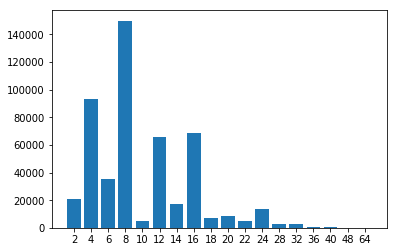

In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
d.sort(key=lambda x: x[0])
x = [a[0] for a in d]
#x.sort()
y = [a[1] for a in d]

plt.bar(range(len(x)), y, align='center')
plt.xticks(range(len(x)), x)

plt.show()

# Conclusion
All bijection have at least 2 orbits so there's no counter

In [46]:
def circuit_to_c(c):
    print(c[0][0][0]+c[0][0][1])
    print(c[0][1][0]+c[0][1][1]+c[0][1][2]+c[0][1][3])
    r = ""
    for i in range(4):
        r += c[0][2][i]+c[1][0][i]
    print(r)
    print(c[1][1][0]+c[1][1][1]+c[1][1][2]+c[1][1][3])
    r = ""
    for i in range(4):
        r += c[1][2][i]+c[2][0][i]
    print(r)
    print(c[2][1][0]+c[2][1][1]+c[2][1][2]+c[2][1][3])
    print(c[2][2][0]+c[2][2][1])

In [64]:
circuit_to_c(((('1', '0'), ('01', '00', '10', '11'), ('1', '1', '0', '0')),
  (('1', '0', '0', '1'), ('01', '00', '10', '11'), ('1', '1', '0', '0')),
  (('1', '0', '0', '1'), ('01', '00', '10', '11'), ('1', '0'))))

10
01001011
11100001
01001011
11100001
01001011
10


NameError: name 'good_2bc_x012' is not defined